<a href="https://colab.research.google.com/github/kacper-dobrow/tensorflow-course/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow part 2: fine-tuning

In the previous notebook we covered feature extraction. Now let's learn fine-tuning.

In [1]:
!nvidia-smi

Thu Oct 26 08:39:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebook we've created some helper functions. However, this is tedious, so let's import them all at once

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-26 08:39:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-26 08:39:30 (89.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import walk_through_dir, unzip_data, plot_loss_curves, create_tensorboard_callback

## Getting data

Using pretrained models contained within TensorFlow, specifically `tf.keras.applications`

In [4]:
# get 10% of training data of 10 classes of food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
#unzip the data
unzip_data("10_food_classes_10_percent.zip")
#walk through directory - check out how many subdirectories and images there are
walk_through_dir("10_food_classes_10_percent/")

--2023-10-26 08:39:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.6.207, 172.217.212.207, 74.125.124.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.6.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   112MB/s    in 1.4s    

2023-10-26 08:39:36 (112 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in 

In [5]:
# Create the training and test directory paths
train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"

Previously we used ImageDataGenerator class. This is the vanilla TensorFlow way.

However, there's a new faster way `tf.keras.utils.image_dataset_from_directory`

In [6]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                                    image_size=IMG_SIZE,
                                                                    label_mode="categorical",
                                                                    batch_size=BATCH_SIZE) #default so not needed
test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=IMG_SIZE,
                                                        label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
# Check out the class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Keras Sequential API - define layers one by one

Keras Functional API - define the following layer as a function into which the previous layer output goes as input

## Model 0: Building a transfer learning model using the Keras Functional API

Functional API is more flexible

In [8]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model layers
base_model.trainable = False

# 3. Create inputs to our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. (optional for EfficientNetB0. If using other models, this strep is necessary) normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model in order to aggregate most important information and reduce number of computations
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling 2D: {x.shape}")

# 7. Create output activation layer
outputs = tf.keras.layers.Dense(len(train_data_10_percent.class_names),
                                activation="softmax",
                                name="output_layer")(x)

# 8. Compine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)), # validating for a quarter of data in order to fit quicker
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="model_0")])

16705208/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling 2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/model_0/20231026-083947
Epoch 1/5
24/24 [==============================] - 23s 254ms/step - loss: 1.9362 - accuracy: 0.3947 - val_loss: 1.3135 - val_accuracy: 0.7599
Epoch 2/5
24/24 [==============================] - 7s 293ms/step - loss: 1.1215 - accuracy: 0.7560 - val_loss: 0.8515 - val_accuracy: 0.8306
Epoch 3/5
24/24 [==============================] - 5s 183ms/step - loss: 0.8009 - accuracy: 0.8133 - val_loss: 0.6732 - val_accuracy: 0.8503
Epoch 4/5
24/24 [==============================] - 5s 188ms/step - loss: 0.6493 - accuracy: 0.8573 - val_loss: 0.5817 - val_accuracy: 0.8668
Epoch 5/5
24/24 [==============================] - 4s 147ms/step - loss: 0.5463 - accuracy: 0.8747 - val_loss: 0.5370 - val_accuracy: 0.8651


In [9]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 7s 77ms/step - loss: 0.5614 - accuracy: 0.8604


[0.5613727569580078, 0.8604000210762024]

In [10]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [11]:
# Get the summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [12]:
# Summary of the whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

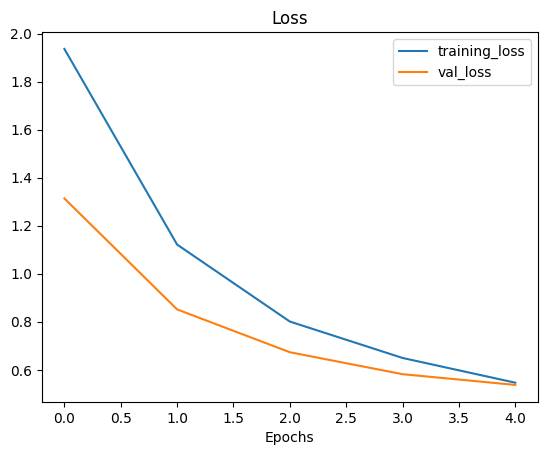

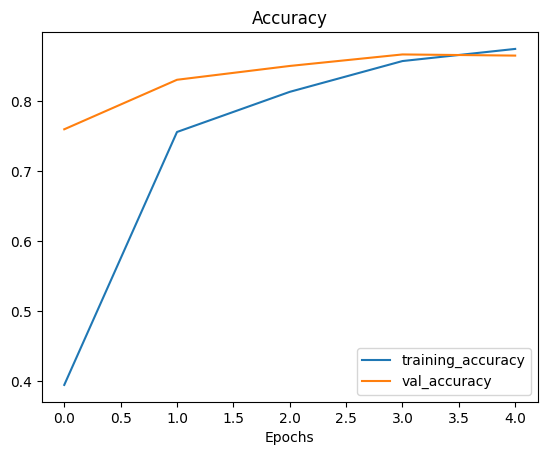

In [13]:
# Check out the model's training curves
plot_loss_curves(history_0)

## Running a series of experiments

1. Feature extraction model with 1% of the training data with data augmentation
2. Feature extraction with 10% of the data and augmantation
3. Fine-tuning on 10% of the training data with data augmentation
4. Fine tuning with 100% of the training data

### Experiment 1: Feature extraction, 1% of the data, augmented

#### Loading and preprocessing data

In [14]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-10-26 08:40:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.103.207, 142.251.172.207, 142.251.120.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.103.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   136MB/s    in 0.9s    

2023-10-26 08:40:42 (136 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [15]:
# Create train and test dirs
train_dir_1 = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [16]:
# How many images are there
walk_through_dir("10_food_classes_1_percent/")

There are 2 directories and 0 images in '10_food_classes_1_percent/'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak

In [17]:
# Set up data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.utils.image_dataset_from_directory(train_dir_1,
                                                                   label_mode="categorical",
                                                                   image_size=IMG_SIZE,
                                                                   batch_size=BATCH_SIZE)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                        label_mode="categorical",
                                                        image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Augmenting the data
Data augmentation is implemented at the level of a layer in our model
* `tf.keras.layers.experimental.preprocessing.()`

The preprocessing layer is only on during training!?!?!?!?

In [18]:
from tensorflow.keras.layers.experimental import preprocessing
# Create augmentation stage with flips, zooms, rotations etc
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
#    preprocessing.Rescale(1./255.)
], name="data_augmentation")

#### Visualize the augmented data

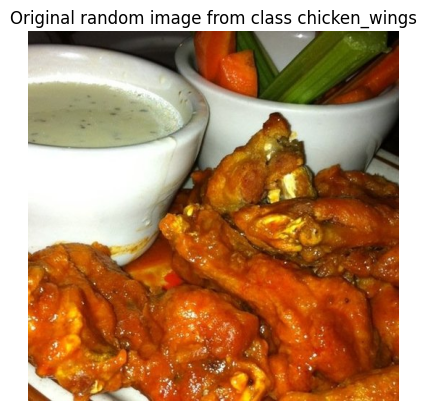

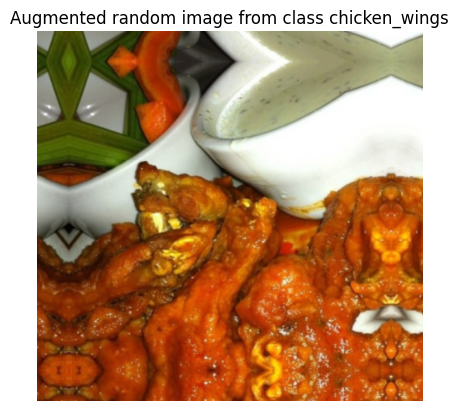

In [19]:
# View a random image before and after augmentation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/"+target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(img/255.)
plt.figure()
plt.imshow(augmented_img)
plt.title(f"Augmented random image from class {target_class}")
plt.axis(False);

#### Building the model

In [20]:
# Setup input shape and base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # removes the output layer as we'll have 10 classes instead of 101000
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add datta augmentation
x = data_augmentation(inputs)

# Pass through the base model
x = base_model(x, training=False)

# Pool the output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

# Put a dense layer as output
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model out of inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="model_1")])

Saving TensorBoard log files to: transfer_learning/model_1/20231026-084048
Epoch 1/5
3/3 [==============================] - 14s 3s/step - loss: 2.2203 - accuracy: 0.1143 - val_loss: 2.1330 - val_accuracy: 0.2385
Epoch 2/5
3/3 [==============================] - 8s 3s/step - loss: 1.9685 - accuracy: 0.2714 - val_loss: 2.0096 - val_accuracy: 0.3470
Epoch 3/5
3/3 [==============================] - 4s 1s/step - loss: 1.8110 - accuracy: 0.4571 - val_loss: 1.8970 - val_accuracy: 0.4112
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.6424 - accuracy: 0.6429 - val_loss: 1.8308 - val_accuracy: 0.4375
Epoch 5/5
3/3 [==============================] - 4s 1s/step - loss: 1.5174 - accuracy: 0.6714 - val_loss: 1.7270 - val_accuracy: 0.5099


In [21]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, 3)           0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [22]:
model_1.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 1.7297 - accuracy: 0.4864


[1.7296583652496338, 0.4864000082015991]

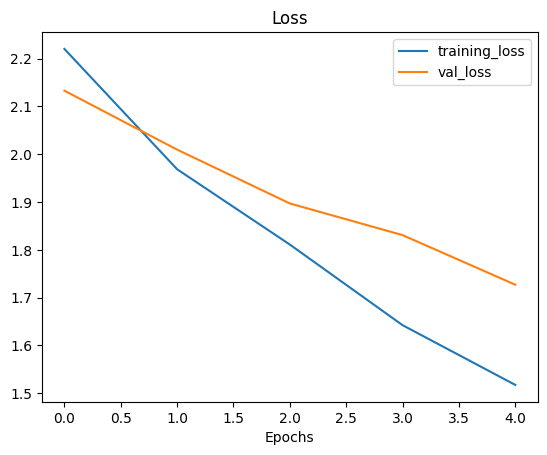

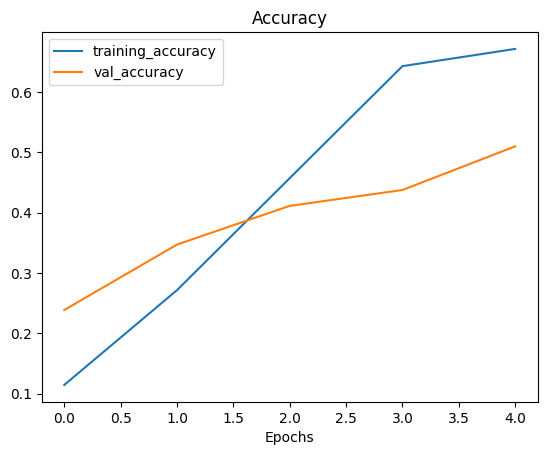

In [23]:
# How does the model do
plot_loss_curves(history_1)

### Experiment 2: Feature extraction, 10% of the data, augmented


In [24]:
# Get 10% of data
train_dir_2 = "10_food_classes_10_percent/train/"
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_2,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [74]:
# Create model 2 with data augmentation in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create the model
model_2 = create_base_model()

# Compile
model_2.compile(optimizer="Adam",
                loss="categorical_crossentropy",
                metrics=["accuracy"])

#### Creating a ModelCheckpoint callback

The ModelCheckpoint intermediately saves our model or just the weights during training.   

In [75]:
# Set checkpoint path
checkpoint_path = "model_2_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback so that it saves the weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=0)

In [76]:
# Fit the model with the ModelCheckpoint callback
initial_epochs = 5
history_2 = model_2.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[checkpoint_callback, create_tensorboard_callback(dir_name="transfer_learning",experiment_name="model_2")])

Saving TensorBoard log files to: transfer_learning/model_2/20231026-124947
Epoch 1/5
24/24 [==============================] - 33s 961ms/step - loss: 2.0625 - accuracy: 0.3200 - val_loss: 1.5550 - val_accuracy: 0.6168
Epoch 2/5
24/24 [==============================] - 18s 714ms/step - loss: 1.4096 - accuracy: 0.6653 - val_loss: 1.0604 - val_accuracy: 0.7549
Epoch 3/5
24/24 [==============================] - 17s 686ms/step - loss: 1.1134 - accuracy: 0.7320 - val_loss: 0.8345 - val_accuracy: 0.7878
Epoch 4/5
24/24 [==============================] - 15s 640ms/step - loss: 0.9364 - accuracy: 0.7747 - val_loss: 0.7562 - val_accuracy: 0.7911
Epoch 5/5
24/24 [==============================] - 15s 580ms/step - loss: 0.8232 - accuracy: 0.8093 - val_loss: 0.6765 - val_accuracy: 0.8092


In [77]:
model_2_results = model_2.evaluate(test_data)

79/79 [==============================] - 9s 104ms/step - loss: 0.6499 - accuracy: 0.8308


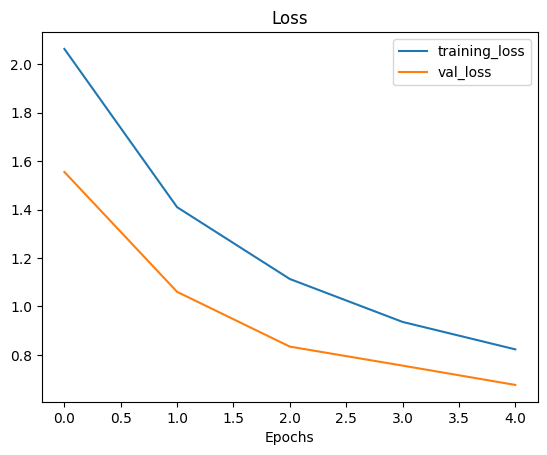

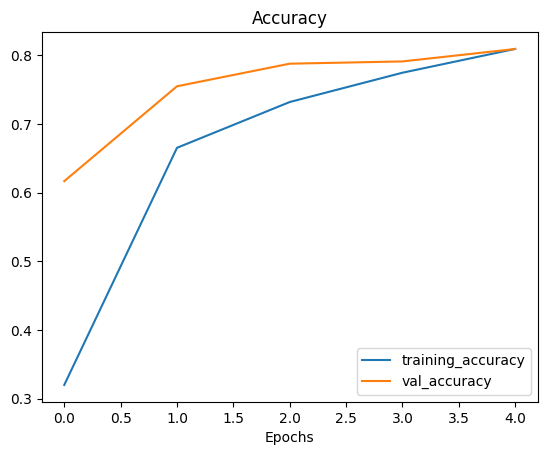

In [78]:
# Plot model loss curves
plot_loss_curves(history_2)

#### Loading the model from a checkpoint

In [79]:
# Load in saved model weights
model_2.load_weights(checkpoint_path)

In [80]:
# Evaluate model_2 with loaded weights
loaded_model_2_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 67ms/step - loss: 0.6499 - accuracy: 0.8308


In [81]:
model_2_results == loaded_model_2_results

True

In [82]:
model_2_results, loaded_model_2_results

([0.6499434113502502, 0.8307999968528748],
 [0.6499434113502502, 0.8307999968528748])

In [83]:
# Check if the model results are very close to our previously trained model
import numpy as np
np.isclose(np.array(model_2_results),np.array(loaded_model_2_results))

array([ True,  True])

In [84]:
# Check the difference
np.array(model_2_results) - np.array(loaded_model_2_results)

array([0., 0.])

### Experiment 3: Fine tuning the existing model on 10% of data
We unfreeze 10 top layers to be trained. Generally you should unfreeze the top layers as the differences in the bottom layers propagate and can destabilize the learning process

Fine tuning usually works better *after* training a feature extraction model for few epochs - so we add a feature extraction layer, then train it, then unfreeze the top layers of the base model and train them.

In [85]:
# Model_3 is just a fine tuned version of thwe model_2
model_2.layers

In [86]:
# Are they trainable
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7fe8c51ed090> True
<keras.src.engine.sequential.Sequential object at 0x7fe960140670> True
<keras.src.engine.functional.Functional object at 0x7fe870e23910> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fe870fb60e0> True
<keras.src.layers.core.dense.Dense object at 0x7fe870e22860> True


In [87]:
# What layers are there in the base model (EfficientNetB0)
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_6 False
1 rescaling_8 False
2 normalization_5 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [88]:
# How many trainable variables are there
len(model_2.layers[2].trainable_variables)


0

In [89]:
# To begin fine-tuning, set last 10 layers of our base model to trainable
base_model.trainable = True

# Freeze all layers but last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [90]:
# Everytime you change a model parameter, you have to recompile
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Learning rate lowered tenfold to make sure we don't change the trainable parameters too much
                loss="categorical_crossentropy",
                metrics=["accuracy"])


Paper on fine-tunung
https://arxiv.org/abs/1801.06146

In [91]:
# Check which layers are tunable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, "Trainable" if layer.trainable else "Not trainable")

0 input_6 Not trainable
1 rescaling_8 Not trainable
2 normalization_5 Not trainable
3 stem_conv Not trainable
4 stem_bn Not trainable
5 stem_activation Not trainable
6 block1a_project_conv Not trainable
7 block1a_project_bn Not trainable
8 block1a_project_activation Not trainable
9 block2a_expand_conv Not trainable
10 block2a_expand_bn Not trainable
11 block2a_expand_activation Not trainable
12 block2a_project_conv Not trainable
13 block2a_project_bn Not trainable
14 block2b_expand_conv Not trainable
15 block2b_expand_bn Not trainable
16 block2b_expand_activation Not trainable
17 block2b_project_conv Not trainable
18 block2b_project_bn Not trainable
19 block2b_drop Not trainable
20 block2b_add Not trainable
21 block3a_expand_conv Not trainable
22 block3a_expand_bn Not trainable
23 block3a_expand_activation Not trainable
24 block3a_project_conv Not trainable
25 block3a_project_bn Not trainable
26 block3b_expand_conv Not trainable
27 block3b_expand_bn Not trainable
28 block3b_expand_acti

In [92]:
#How many trainable variables are there
print(len(model_2.trainable_variables))

2


In [93]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model, the same as model 2 but with more trainable layers
history_3 = model_2.fit(train_data_10_percent,
                        epochs=fine_tune_epochs,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        initial_epoch=history_2.epoch[-1], # start training from previous last epoch
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="model_3")])

Saving TensorBoard log files to: transfer_learning/model_3/20231026-125205
Epoch 5/10
24/24 [==============================] - 25s 686ms/step - loss: 0.7486 - accuracy: 0.8200 - val_loss: 0.6611 - val_accuracy: 0.8257
Epoch 6/10
24/24 [==============================] - 13s 543ms/step - loss: 0.7500 - accuracy: 0.8173 - val_loss: 0.6545 - val_accuracy: 0.8273
Epoch 7/10
24/24 [==============================] - 15s 605ms/step - loss: 0.7466 - accuracy: 0.8133 - val_loss: 0.6507 - val_accuracy: 0.8322
Epoch 8/10
24/24 [==============================] - 12s 483ms/step - loss: 0.7419 - accuracy: 0.8213 - val_loss: 0.6266 - val_accuracy: 0.8372
Epoch 9/10
24/24 [==============================] - 13s 537ms/step - loss: 0.7223 - accuracy: 0.8173 - val_loss: 0.6258 - val_accuracy: 0.8224
Epoch 10/10
24/24 [==============================] - 15s 597ms/step - loss: 0.7157 - accuracy: 0.8213 - val_loss: 0.6227 - val_accuracy: 0.8322


In [94]:
# Evaluate the fine tuned model
fine_tuned_model_2_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 85ms/step - loss: 0.6062 - accuracy: 0.8384


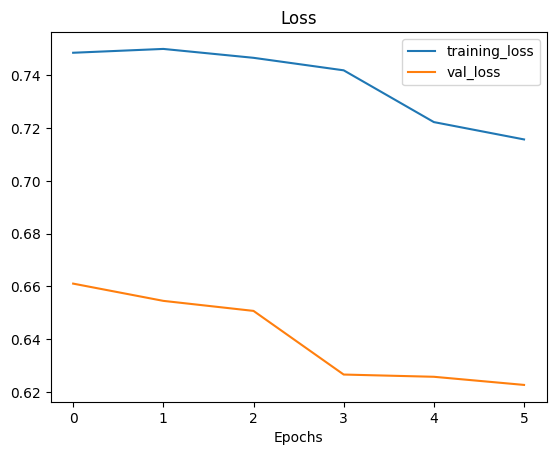

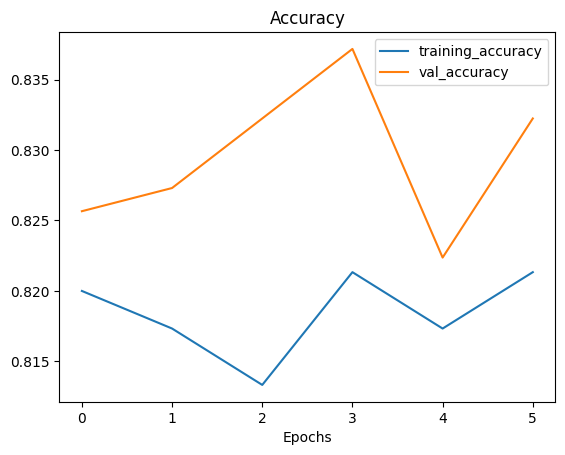

In [95]:
plot_loss_curves(history_3)

In [96]:
# Create a fcn to plot loss curves after two training sessions
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares 2 tf history objects
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history metrics with new history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots
  plt.figure(figsize=(8, 8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.ylim([0.,1.])
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.title("Accuracy")
  plt.legend(loc="lower right")

  plt.subplot(2,1,2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")
  plt.ylim(bottom=0.)
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Loss")

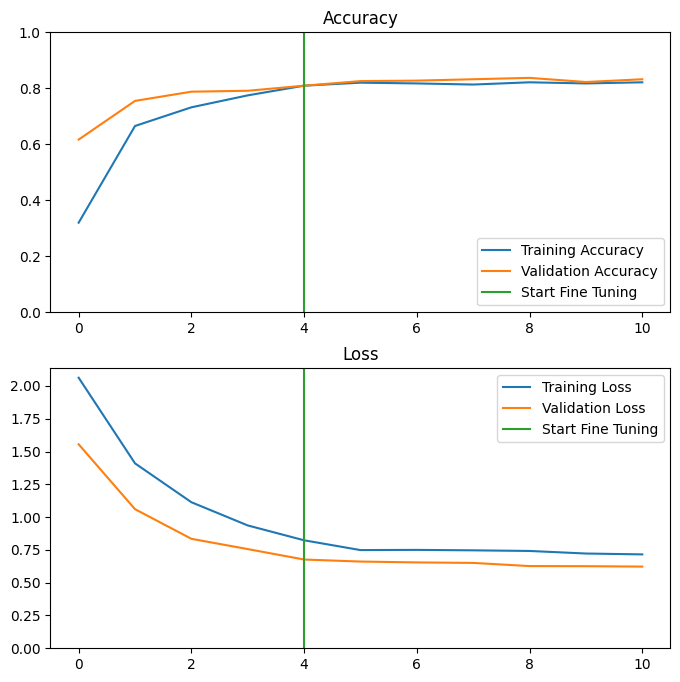

In [97]:
compare_histories(history_2, history_3)

### Experiment 4: Fine tuning on 100% of data

In [98]:
# Download and unzip all the images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2023-10-26 12:53:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.207, 209.85.147.207, 142.250.125.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  58.0MB/s    in 6.0s    

2023-10-26 12:53:59 (83.1 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [99]:
# Setup training and test dir
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [100]:
# How many images are there
walk_through_dir("10_food_classes_all_data/")

There are 2 directories and 0 images in '10_food_classes_all_data/'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are

In [101]:
# Setup data inputs
IMG_SIZE = (224, 224)
train_data_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                      label_mode="categorical",
                                                                      image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [102]:
# Evaluate model_2 fine tuned on 10% of data
model_2.evaluate(test_data)


79/79 [==============================] - 6s 68ms/step - loss: 0.6062 - accuracy: 0.8384


[0.6062111854553223, 0.8384000062942505]

We need lo load the model in the state after feature extraction, before fine tuning

In [113]:
# Create new model, because running the following cell as is produces error
model_4 = create_base_model(learning_rate=0.0001)

In [114]:
# Load the weights from checkpoint
model_4.load_weights(checkpoint_path)

In [115]:
# Let's evaluate model_4
model_4.evaluate(test_data)

79/79 [==============================] - 10s 80ms/step - loss: 0.6499 - accuracy: 0.8308


[0.6499435305595398, 0.8307999968528748]

In [116]:
# we've reverted to the feature extraction times
model_2_results

[0.6499434113502502, 0.8307999968528748]

In [117]:
# Check how many of model_4 layers are tunable
for layer_number, layer in enumerate(model_4.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_9 False
1 rescaling_11 False
2 normalization_8 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2

In [118]:
for layer in model_4.layers[2].layers[-10:]:
  layer.trainable = True

In [119]:
for layer_number, layer in enumerate(model_4.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)


0 input_9 False
1 rescaling_11 False
2 normalization_8 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2

In [121]:
model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

In [122]:
# Fit
fine_tune_epochs = initial_epochs + 5
history_4 = model_4.fit(train_data_full,
                        steps_per_epoch=len(train_data_full),
                        epochs = fine_tune_epochs,
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        initial_epoch=history_2.epoch[-1],
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="model_4")])

Saving TensorBoard log files to: transfer_learning/model_4/20231026-132620
Epoch 5/10
235/235 [==============================] - 102s 380ms/step - loss: 0.8682 - accuracy: 0.7524 - val_loss: 0.6022 - val_accuracy: 0.8470
Epoch 6/10
235/235 [==============================] - 78s 329ms/step - loss: 0.8039 - accuracy: 0.7688 - val_loss: 0.5477 - val_accuracy: 0.8536
Epoch 7/10
235/235 [==============================] - 73s 307ms/step - loss: 0.7592 - accuracy: 0.7796 - val_loss: 0.5200 - val_accuracy: 0.8503
Epoch 8/10
235/235 [==============================] - 59s 249ms/step - loss: 0.7247 - accuracy: 0.7871 - val_loss: 0.4676 - val_accuracy: 0.8668
Epoch 9/10
235/235 [==============================] - 53s 224ms/step - loss: 0.7007 - accuracy: 0.7921 - val_loss: 0.4753 - val_accuracy: 0.8586
Epoch 10/10
235/235 [==============================] - 50s 213ms/step - loss: 0.6870 - accuracy: 0.7973 - val_loss: 0.4525 - val_accuracy: 0.8766


In [123]:
model_4.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.4377 - accuracy: 0.8744


[0.4376903772354126, 0.8744000196456909]

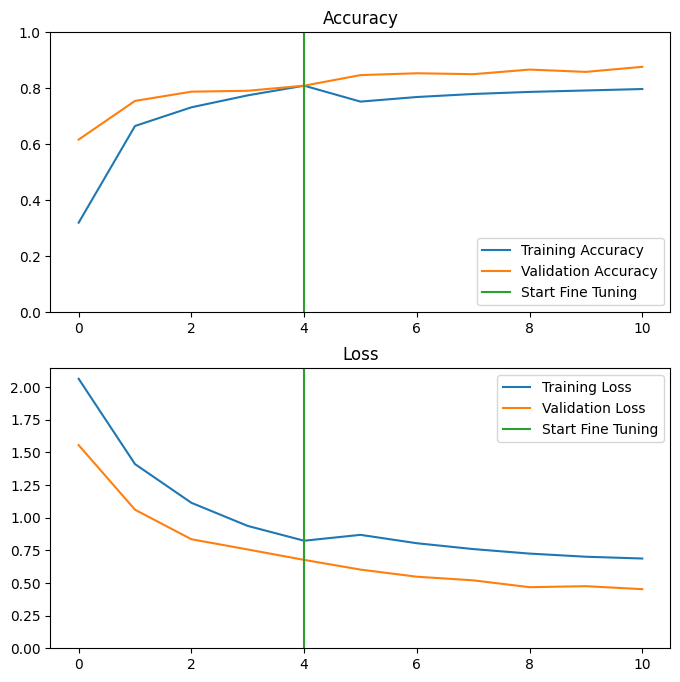

In [124]:
compare_histories(history_2, history_4)